In [1]:
# To use cleaning process if needed
from utils import *

from config_file import DOWNLOAD_ROOT, DATASETS_PATH, DOWNLOAD_URL, TWEETS_PATH

In [2]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
PROJECT_ID = "happiness_over_countries"

if not os.path.isdir("images"):
        os.makedirs("images")
        
IMAGE_PATH = os.path.join("images", PROJECT_ID)

if not os.path.isdir(IMAGE_PATH):
        os.makedirs(IMAGE_PATH)
        
IMAGES_STORE_PATH = os.path.join(PROJECT_ROOT_DIR, IMAGE_PATH)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_STORE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [3]:
import pandas as pd
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
import string
import unicodedata
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.ml.feature import StopWordsRemover
import re
from pyspark.conf import SparkConf
from pyspark.sql import functions as F
import string
import csv
from pyspark.sql.types import StringType
from pyspark.sql.types import ArrayType
import os
import conda
from mpl_toolkits.basemap import Basemap

In [4]:
spark = SparkSession.builder\
    .master("local[*]")\
    .appName("nlp")\
    .config("spark.executor.memory", "32g")\
    .config("spark.driver.memory", "32g")\
    .config("spark.memory.offHeap.enabled",True) \
    .config("spark.memory.offHeap.size","16g")\
    .config("spark.debug.maxToStringFields","200")\
    .getOrCreate()

In [5]:
extract_tar_file(tgz_name = "preproccessed_tweets_location.tar.gz")

Saving figure 1_happiness_over_location
Saving figure 2_happiness_over_location
Saving figure 3_happiness_over_location
Saving figure 4_happiness_over_location


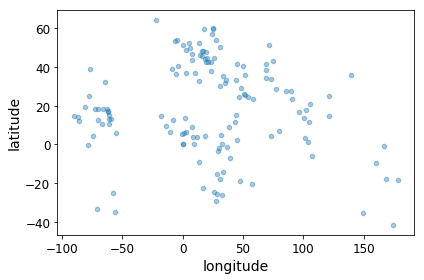

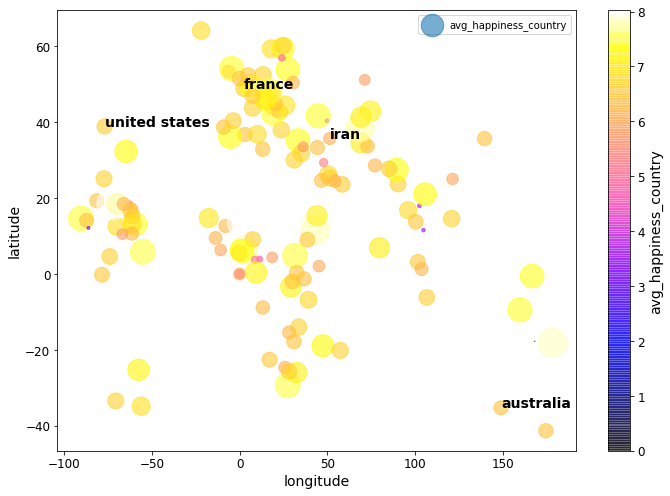

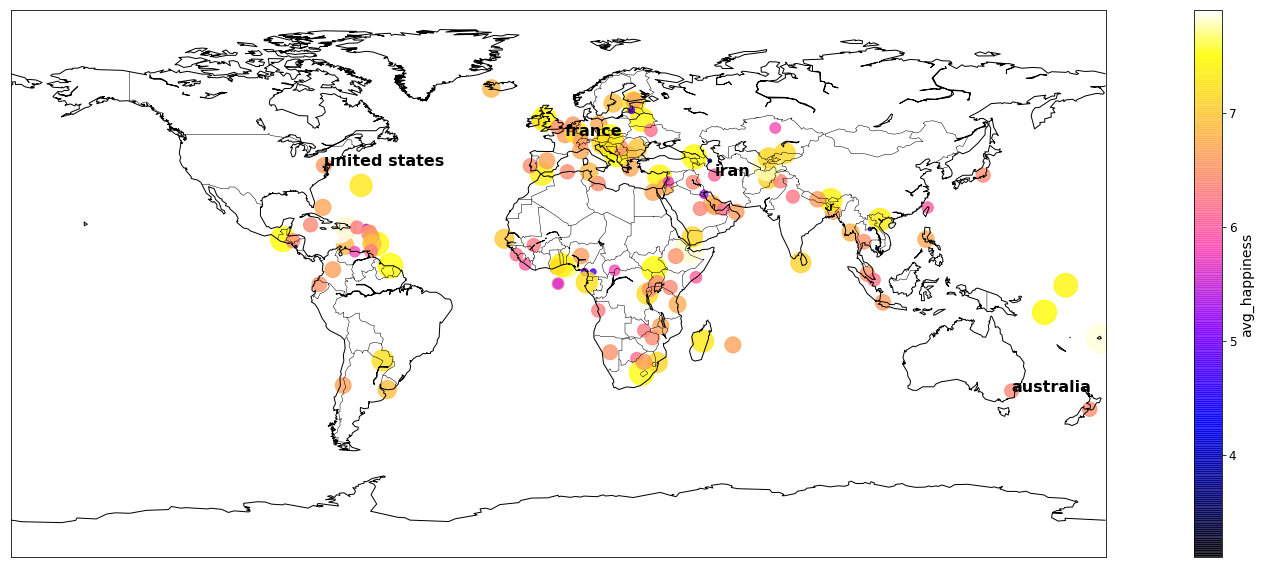

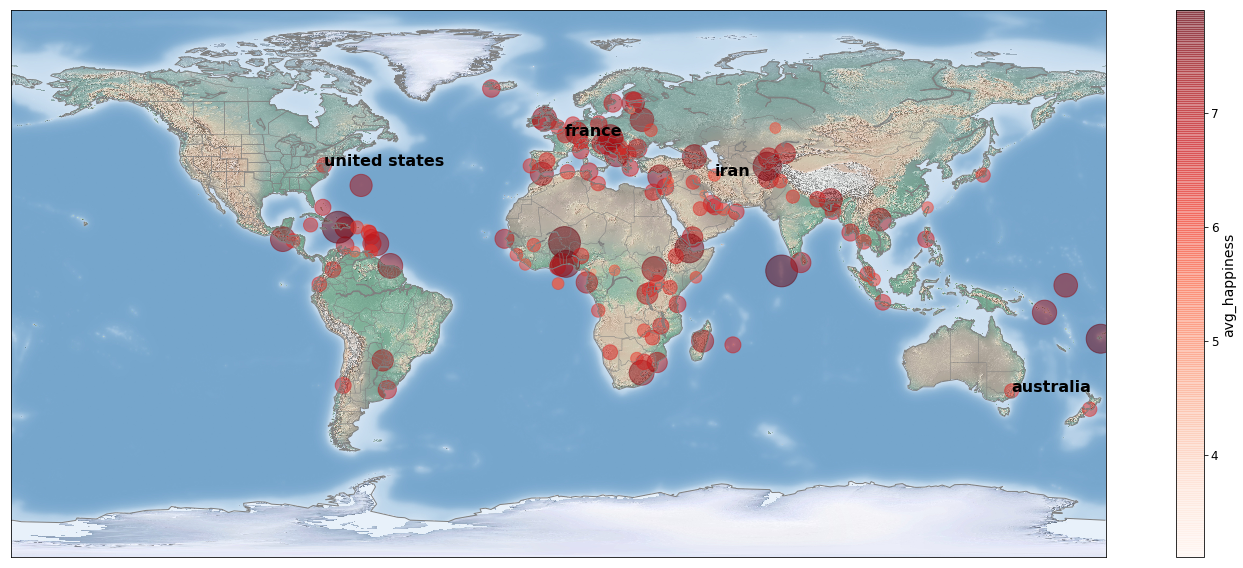

In [16]:
# following file contains the location name and avarage happiness for the related tweet
countries_happiness = spark.read.json('./datasets/countries_happiness/countries_happiness.json')

latitude_longitude= load_data(DATASETS_PATH, 'country_capitals.csv')
latitude_longitude= latitude_longitude.select('countryName','capitalLatitude','capitalLongitude')

df_final = avg_happiness_over_country(countries_happiness, 'location', 'happiness_avg')

latitude_longitude = lower_words(latitude_longitude)
latitude_longitude = lower_words(latitude_longitude)
latitude_longitude = latitude_longitude.selectExpr('countryName as location', 
                                                   'capitalLongitude as longitude',
                                                   'CapitalLatitude as latitude')

df = df_final.join(latitude_longitude, on='location', how = 'inner').sort('location')
df = df.withColumn("latitude", df["latitude"].cast("float"))
df = df.withColumn("longitude", df["longitude"].cast("float"))
df_pd = df.toPandas()

df_pd.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4)
save_fig("1_happiness_over_location")

ax = df_pd.plot(kind="scatter", x="longitude", y="latitude", alpha=0.6,
    s= np.exp(df_pd["avg_happiness_country"])/3, label="avg_happiness_country",
    figsize=(10,7), c="avg_happiness_country", cmap=plt.get_cmap("gnuplot2"), colorbar=True,
    sharex=False)

for i, txt in enumerate(df_pd.location):
    if txt == 'iran' or txt == 'united states' or txt == 'france' or txt == 'australia':
        ax.annotate(txt, (df_pd.longitude.iat[i], df_pd.latitude.iat[i]), fontsize=14 ,fontweight ='bold')

save_fig("2_happiness_over_location")

lat = df_pd['latitude'].values
lon = df_pd['longitude'].values
avg_hap = df_pd['avg_happiness_country'].values
location = df_pd['location'].values

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib
fig = plt.figure(figsize=(25, 8))
map = Basemap()
map.drawcoastlines()
#map.fillcontinents(color="#FFDDCC", lake_color='#DDEEFF')
#map.drawmapboundary(fill_color="#DDEEFF")
map.drawcountries()

map.scatter(lon, lat, latlon=True,
          c= avg_hap, s= np.exp(avg_hap)/3,
          cmap=plt.get_cmap("gnuplot2"), alpha=0.8)

plt.colorbar(label='avg_happiness')
plt.clim(3.1,7.9)


for i, txt in enumerate(df_pd.location):
    if txt == 'iran' or txt == 'united states' or txt == 'australia' or txt == 'france':
        plt.annotate(txt, (df_pd.longitude.iat[i], df_pd.latitude.iat[i]), fontsize = 16 ,fontweight='bold')
        
save_fig("3_happiness_over_location")

fig = plt.figure(figsize=(20, 8))
m = Basemap()

m.shadedrelief()
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')

# 2. scatter city data, with color reflecting population
# and size reflecting area
m.scatter(lon, lat, latlon=True,
          c= avg_hap, s=np.exp(avg_hap)/3,
          cmap='Reds', alpha=0.5)

plt.colorbar(label='avg_happiness')
plt.clim(3.1,7.9 )


for i, txt in enumerate(df_pd.location):
    if txt == 'iran' or txt == 'united states' or txt == 'australia' or txt == 'france':
        plt.annotate(txt, (df_pd.longitude.iat[i], df_pd.latitude.iat[i]), fontsize = 16 ,fontweight='bold')
        
save_fig("4_happiness_over_location")


In [19]:
df.show(2)

+-----------+---------------------+---------+---------+
|   location|avg_happiness_country|longitude| latitude|
+-----------+---------------------+---------+---------+
|afghanistan|                 7.06|69.183334|34.516666|
|    algeria|            6.4318204|     3.05|    36.75|
+-----------+---------------------+---------+---------+
only showing top 2 rows



In [33]:
order_avg = df.select('location','avg_happiness_country').orderBy('avg_happiness_country', ascending= False)

In [42]:
order_avg.show(10)

+----------+---------------------+
|  location|avg_happiness_country|
+----------+---------------------+
|  maldives|                 8.02|
|     niger|                 8.02|
|     haiti|                 8.02|
|      fiji|            7.8333335|
|  djibouti|                 7.82|
|tajikistan|                7.785|
|     benin|            7.6905556|
|  slovakia|            7.5403333|
|   lesotho|                7.533|
|  suriname|                 7.52|
+----------+---------------------+
only showing top 10 rows



In [56]:
order_avg.select('location', 'avg_happiness_country').where((col('avg_happiness_country')<7) &  
                                                           (col('avg_happiness_country')>6)).\
orderBy('avg_happiness_country', ascending=False).show(80)

+--------------------+---------------------+
|            location|avg_happiness_country|
+--------------------+---------------------+
|             senegal|             6.995509|
|             romania|             6.977902|
|saint vincent and...|            6.9109106|
|             uruguay|             6.909425|
|              sweden|             6.894154|
|               aruba|            6.8445835|
|             tunisia|             6.841963|
|             iceland|            6.8251667|
|             myanmar|                 6.79|
|             bahrain|                 6.79|
|            tanzania|             6.754239|
|              israel|            6.7205415|
|             austria|             6.707123|
|         philippines|            6.6987996|
|             germany|            6.6979117|
|               egypt|            6.6952505|
|              monaco|             6.693278|
|              greece|             6.689656|
|              malawi|            6.6719193|
|         

In [7]:
h_avg = sc.textFile(os.path.join(DATASETS_PATH, "Data_Set_S1.txt")).\
        mapPartitions(lambda line:csv.reader(line,delimiter='\t', quotechar='"')).\
        filter(lambda line: len(line)>=2 and line[0]!= 'word').\
        toDF(["word", "happiness_rank", "happiness_average","happiness_standard_deviation",
               "twitter_rank", "google_rank", "nyt_rank", "lyrics_rank"])

In [8]:
df = h_avg.select('word','happiness_average') 

In [9]:
df = df.withColumn("happiness_average", df["happiness_average"].cast("double"))

In [10]:
df = df.toPandas()

In [11]:
df_ = df.loc[(df["happiness_average"] > 8.40) | (df["happiness_average"]==5.0) | (df["happiness_average"]<1.50)]

In [12]:
df_.head(100)

,word,happiness_average
0,laughter,8.50
1,happiness,8.44
2,love,8.42
7153,'cause,5.00
7158,because,5.00
7211,reports,5.00
7226,throw,5.00
7233,using,5.00
10218,murder,1.48
10219,terrorism,1.48


Saving figure happines_word


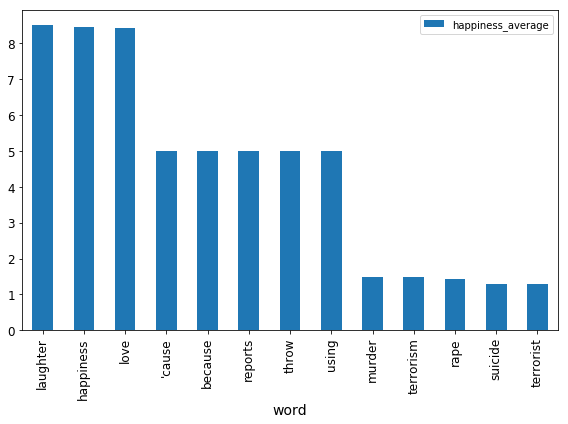

In [13]:
df_.plot(kind="bar", x="word", figsize=(8,6), )
save_fig("happines_word")

In [17]:
df_pd.head(2)

,location,avg_happiness_country,longitude,latitude
0,afghanistan,7.06000,69.183334,34.516666
1,algeria,6.43182,3.050000,36.750000
